In [17]:
import numpy as np
from prototypes.utility.data import DataLoader
from prototypes.utility.data import ProjectConfiguration
import matplotlib.pyplot as plt
from prototypes.classical.segmentation.transformers import BlackBarsRemover, OtsuThresholdingSegmentation
from prototypes.classical.descriptors.texture import LBPTransformer, GaborTransformer, HoGTransformer, GaborTransformerBank
from prototypes.classical.descriptors.vetorizer import PCAVectorizer
import cv2

%load_ext autoreload
%autoreload 2

Find a way to discriminate between 2 groups.

Benign and Malignant tumors in skin images.

Describing both by gabor texture banks, then reduce dimensions training a pca.

In [18]:
config = ProjectConfiguration("../config.json")

In [19]:
config.get_keys()

dict_keys(['DATASET_PATH', 'TRAIN_IMAGES_PATH', 'TRAIN_METADATA', 'TEST_METADATA', 'SAMPLE_SUBMISSION', 'IMAGE_WIDTH', 'IMAGE_HEIGHT', 'TARGET_COLUMNS', 'VECTORS_PATH', 'BATCH_SIZE', 'K_FOLDS', 'SAMPLE_PERCENTAGE', 'HYPER_PARAMETERS_PATH', 'VERSION'])

In [20]:
data_loader = DataLoader(data_path=config.get_value("TRAIN_IMAGES_PATH"), metadata_path=config.get_value("TRAIN_METADATA"))

In [21]:
MALIGN_SAMPLES = 190
BENIGN_SAMPLES = 15000

malign_images = data_loader.get_data(target=1, width=64, height=64, mode="gray")[:MALIGN_SAMPLES]
bening_images = data_loader.get_data(target=0, width=64, height=64, mode="gray")[:BENIGN_SAMPLES]
otsu_thresholding = OtsuThresholdingSegmentation()
lbp_transformer = LBPTransformer(p=8, r=1)

# Distribution based on gabor banks

In [22]:
x = np.linspace(-255, 256, 256)

def gaussian_dist(x, mean, std):
    return (1/(std*np.sqrt(2*np.pi))) * np.exp(-(x-mean)**2/(2*std**2))

In [23]:
gabor_banks = [GaborTransformer(frequency=1/100, theta=np.pi/4, sigma_x=5, sigma_y=5),
               GaborTransformer(frequency=1/100, theta=np.pi/2, sigma_x=5, sigma_y=5),
               GaborTransformer(frequency=1/100, theta=np.pi, sigma_x=5, sigma_y=5)]

gabor_transformer = GaborTransformerBank(gabor_banks=gabor_banks)

In [24]:
gabor_benign = gabor_transformer.transform(bening_images)
gabor_malignant = gabor_transformer.transform(malign_images)

In [25]:
from prototypes.classical.descriptors.vetorizer import PCAVectorizer

In [26]:
gabor_benign.shape, gabor_malignant.shape

((15000, 3, 64, 64), (190, 3, 64, 64))

In [27]:
pca_vectorizer_b = PCAVectorizer(n_components=32, batch_size=512)
pca_vectorizer_b.fit(gabor_benign)

In [28]:
pca_vectorizer_m = PCAVectorizer(n_components=32, batch_size=512)
pca_vectorizer_m.fit(gabor_malignant)

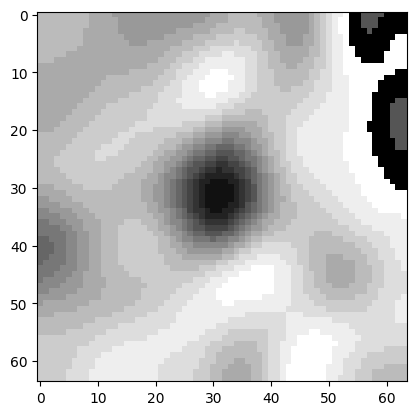

In [29]:
plt.imshow(gabor_benign[0][0], "gray")

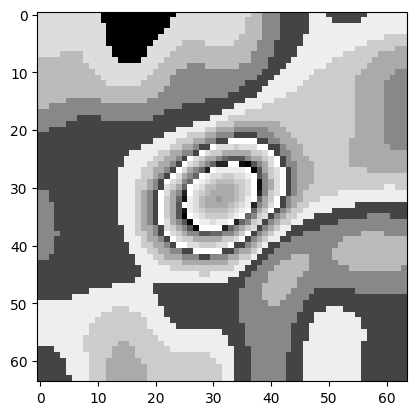

In [30]:
plt.imshow(gabor_benign[-1][0], "gray")

# mean and std for each component of the PCA to make a distribution

In [31]:
pca_gabor_benign = pca_vectorizer_b.transform(gabor_benign)
pca_gabor_malignant = pca_vectorizer_m.transform(gabor_malignant)

In [32]:
pca_gabor_benign.shape, gabor_malignant.shape

((15000, 32), (190, 3, 64, 64))

In [33]:
def print_gaussian(pca_gabor_benign, pca_gabor_malignant, component):
    mean_benign = pca_gabor_benign[:, component].mean()
    std_benign = pca_gabor_benign[:, component].std()
    
    mean_malignant = pca_gabor_malignant[:, component].mean()
    std_malignant = pca_gabor_malignant[:, component].std()
    
    plt.plot(x, gaussian_dist(x, mean_benign, std_benign), label=f"Benign-component-{component}")
    plt.plot(x, gaussian_dist(x, mean_malignant, std_malignant), label=f"Malignant-{component}")

    plt.legend()
    plt.show()

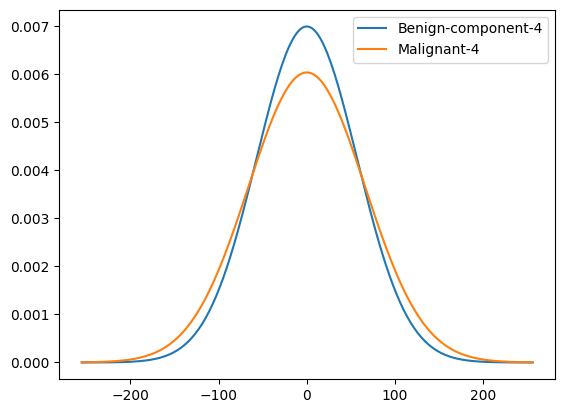

In [34]:
print_gaussian(pca_gabor_benign, pca_gabor_malignant, 4)

# Blending images

In [35]:
def blend_image(image1, image2, alpha):
    random_sample = np.random.beta(alpha, alpha, 1)
    return (random_sample * image1 + (1-random_sample) * image2)

In [36]:
blended_image = blend_image(bening_images[31], malign_images[8], 0.2)

In [37]:
blended_image.max(), blended_image.min()

(106.00000003608982, 16.000000129321833)

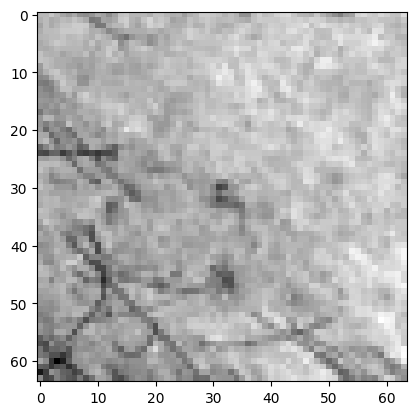

In [38]:
plt.imshow(blended_image, "gray")

In [39]:
blended_gabor_image = gabor_transformer.transform([blended_image])
#

image_1_gabor = gabor_transformer.transform([bening_images[31]])
image_2_gabor = gabor_transformer.transform([malign_images[8]]) 
# 

blended_pca_transform_m = pca_vectorizer_m.transform(blended_gabor_image)
blended_pca_transform_b = pca_vectorizer_b.transform(blended_gabor_image)

image_1_pca_b = pca_vectorizer_b.transform(image_1_gabor)
image_2_pca_m = pca_vectorizer_m.transform(image_2_gabor)

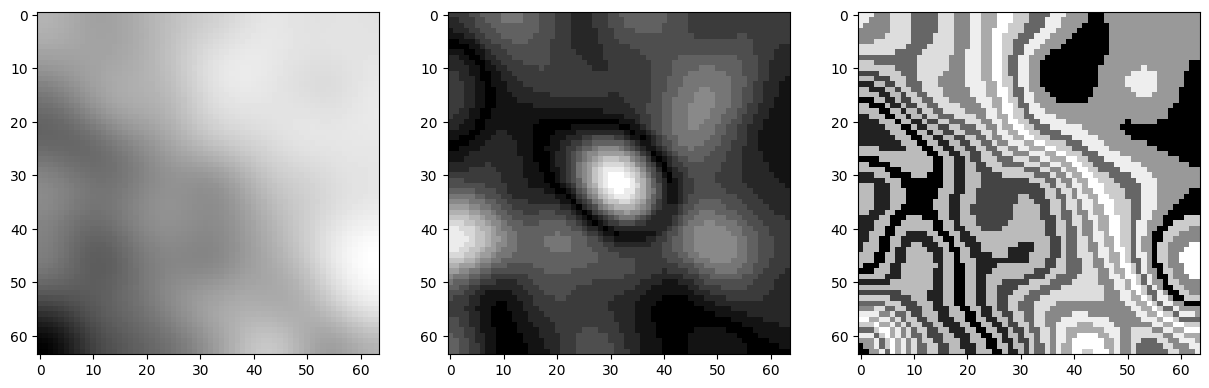

In [40]:
_, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(blended_gabor_image[0][0], "gray")
ax[1].imshow(image_1_gabor[0][0], "gray")
ax[2].imshow(image_2_gabor[0][0], "gray")

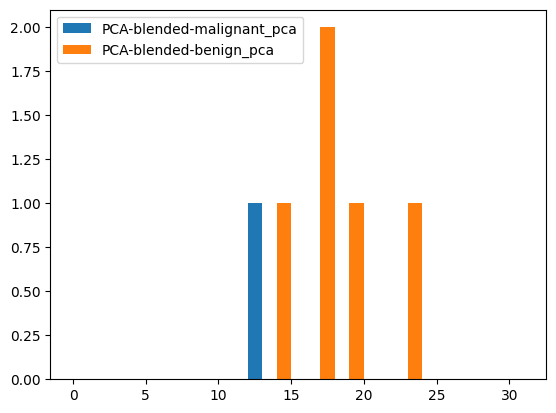

In [41]:
plt.hist(blended_pca_transform_m[0], range(len(blended_pca_transform_m[0])), label="PCA-blended-malignant_pca")
plt.hist(blended_pca_transform_b[0], range(len(blended_pca_transform_b[0])), label="PCA-blended-benign_pca")

plt.legend()
plt.show()

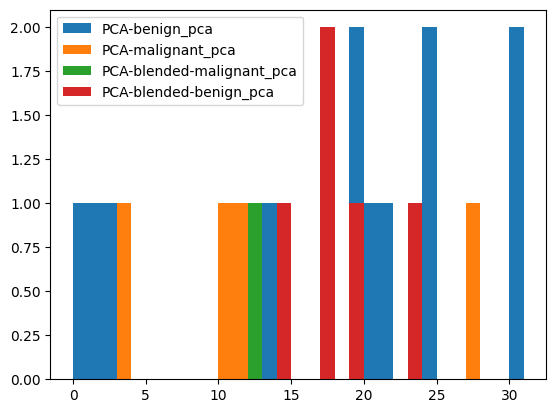

In [42]:
plt.hist(image_1_pca_b[0], range(len(image_1_pca_b[0])), label="PCA-benign_pca")
plt.hist(image_2_pca_m[0], range(len(image_2_pca_m[0])), label="PCA-malignant_pca")

plt.hist(blended_pca_transform_m[0], range(len(blended_pca_transform_m[0])), label="PCA-blended-malignant_pca")
plt.hist(blended_pca_transform_b[0], range(len(blended_pca_transform_b[0])), label="PCA-blended-benign_pca")

plt.legend()
plt.show()

# thresholding first

In [43]:
otsu_thresholding_transform = OtsuThresholdingSegmentation()
remove_black_bars_transform = BlackBarsRemover()

In [44]:
bening_thresholded = otsu_thresholding_transform.transform(bening_images)
malignant_thresholded = otsu_thresholding_transform.transform(malign_images)

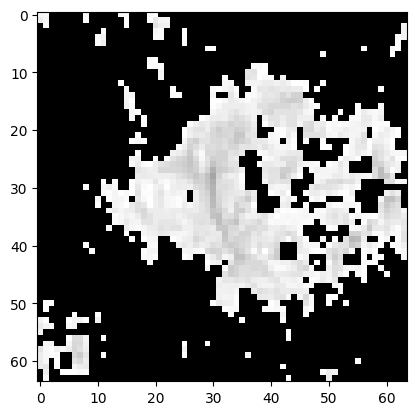

In [45]:
plt.imshow(malignant_thresholded[2], "gray")

In [46]:
bening_images_thresholded_gabor = gabor_transformer.transform(bening_thresholded)
malign_images_thresholded_gabor = gabor_transformer.transform(malignant_thresholded)

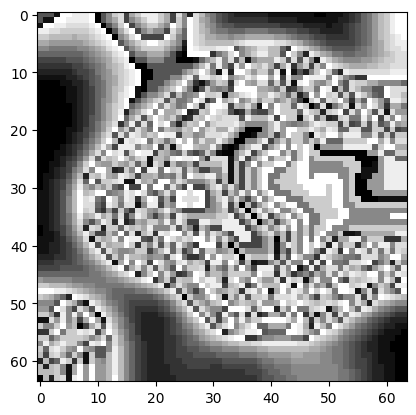

In [47]:
plt.imshow(malign_images_thresholded_gabor[2][0], "gray")

In [48]:
bening_images_thresholded_gabor.shape

(15000, 3, 64, 64)

In [49]:
pca_vectorizer_b = PCAVectorizer(n_components=32, batch_size=512)
pca_vectorizer_m = PCAVectorizer(n_components=32, batch_size=512)

pca_vectorizer_b.fit(bening_images_thresholded_gabor)
pca_vectorizer_m.fit(malign_images_thresholded_gabor)

pca_bening_thresholded_gabor = pca_vectorizer_b.transform(bening_images_thresholded_gabor)
pca_malignant_thresholded_gabor = pca_vectorizer_m.transform(malign_images_thresholded_gabor)

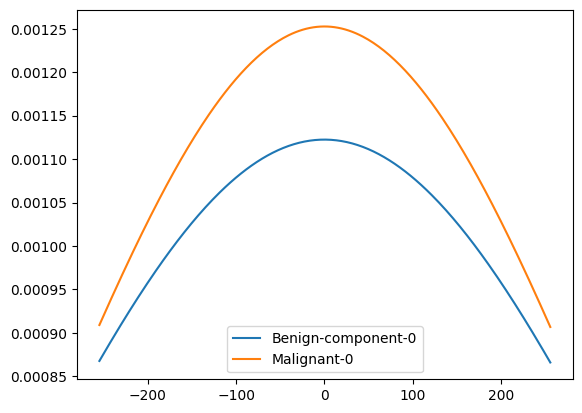

In [50]:
print_gaussian(pca_bening_thresholded_gabor, pca_malignant_thresholded_gabor, 0)

# threshold blending

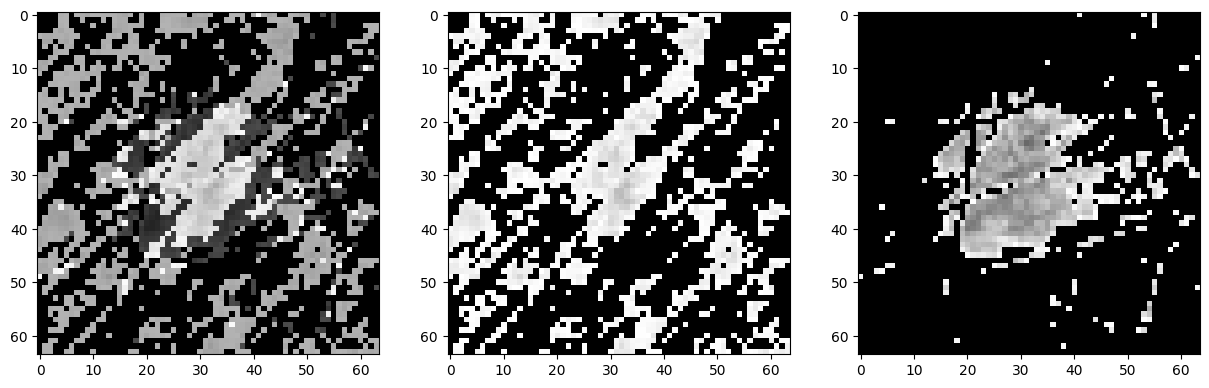

In [51]:
index_1 = 0
index_2 = 10

blended_image = blend_image(bening_thresholded[index_1], malignant_thresholded[index_2], 0.2)

_, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(blended_image, "gray")
ax[1].imshow(bening_thresholded[index_1], "gray")
ax[2].imshow(malignant_thresholded[index_2], "gray")

In [52]:
def mix_up_data(x, y, alpha):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    #x.size()[0]
    batch_size = x.shape[0]
    # index = torch.randperm(batch_size)
    index = np.random.permutation(range(batch_size))
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [53]:
X = np.vstack((bening_images, malign_images))
y = np.vstack((np.zeros((len(bening_images), 1)), np.ones((len(malign_images), 1))))

mixed_x, y_a, y_b, lam = mix_up_data(X, y, 0.2)

In [54]:
from sklearn.ensemble import HistGradientBoostingRegressor

features = mixed_x.astype(np.uint8)

# features = otsu_thresholding.transform(features)
features = gabor_transformer.transform(features)
pca_vectorizer_mix = PCAVectorizer(n_components=32, batch_size=512)
pca_vectorizer_mix.fit(features)
features = pca_vectorizer_mix.transform(features) 

In [55]:
features.shape

(15190, 32)

In [56]:
hgrd = HistGradientBoostingRegressor()

In [57]:
np.hstack((y_a, y_b)).shape

(15190, 2)

In [58]:
hgrd.fit(features, (y_a * lam + (1-lam) * y_b).ravel())

HistGradientBoostingRegressor()

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


preds = hgrd.predict(features)
print(classification_report(y_true=y, y_pred=preds>0.5))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15000
         1.0       0.00      0.00      0.00       190

    accuracy                           0.99     15190
   macro avg       0.49      0.50      0.50     15190
weighted avg       0.98      0.99      0.98     15190



/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [60]:
test_malign_images = data_loader.get_data(target=1, width=64, height=64, mode="gray")[MALIGN_SAMPLES: ]
test_bening_images = data_loader.get_data(target=0, width=64, height=64, mode="gray")[BENIGN_SAMPLES: BENIGN_SAMPLES*2]

X = np.vstack((test_malign_images, test_bening_images))
y_test = np.vstack((np.zeros((len(test_bening_images), 1)), np.ones((len(test_malign_images), 1))))

test_features = X

# test_features = otsu_thresholding.transform(test_features)
test_features = gabor_transformer.transform(test_features)
test_features = pca_vectorizer_mix.transform(test_features) 

preds = hgrd.predict(test_features)
print(classification_report(y_true=y_test, y_pred=preds>0.5))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15000
         1.0       0.00      0.00      0.00       203

    accuracy                           0.99     15203
   macro avg       0.49      0.50      0.50     15203
weighted avg       0.97      0.99      0.98     15203



/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matias/pythonenv/kaggle-isic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r